# **Logistic Regression Model:**


In [2]:
# import libraries
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer

# import logistic regression model
from sklearn.linear_model import LogisticRegression



---



# **Metrics:**


**ROC AUC:**

In [7]:
def rocauc(true, score):
    # sort indices and actuals by probability
    sorted_indices = np.argsort(score)
    true_sort = true[sorted_indices]

    # sort the probability
    score_sort = score[sorted_indices]

    # TP vector, FP vector
    TP = np.cumsum(true_sort)
    FP = np.cumsum(1 - true_sort)

    # TPR vector, FPR vector
    TPR = TP / TP[-1]
    FPR = FP / FP[-1]

    # area under curve (TPR vs. FPR)
    rocauc_score = np.trapz(FPR, TPR)

    return rocauc_score

**Accuracy, Precision, Recall, F1 Score:**

In [6]:
def metrics(true, pred):
    # get TP, TN, FP, FN
    TP = np.sum((pred == 1) & (true == 1))
    TN = np.sum((pred == 0) & (true == 0))
    FP = np.sum((pred == 1) & (true == 0))
    FN = np.sum((pred == 0) & (true == 1))

    # accuracy
    accuracy = (TP + TN) / (TP + TN + FP + FN)

    # precision
    if TP + FP > 0:
        precision = TP / (TP + FP)
    else:
        precision = 0

    # recall
    if TP + FN > 0:
        recall = TP / (TP + FN)
    else:
        recall = 0

    # f1 score
    f1 = 0
    if precision + recall > 0:
        f1 = 2 * precision * recall / (precision + recall)
    else:
        recall = 0

    return accuracy, precision, recall, f1

**Matthew's Correlation Coefficient:**

In [8]:
def matthews_correlation_coefficient(y_true, y_pred):
    tp = sum((y_true == 1) & (y_pred == 1))
    tn = sum((y_true == 0) & (y_pred == 0))
    fp = sum((y_true == 0) & (y_pred == 1))
    fn = sum((y_true == 1) & (y_pred == 0))

    numerator = (tp * tn) - (fp * fn)
    denominator = ((tp + fp) * (tp + fn) * (tn + fp) * (tn + fn)) ** 0.5

    if denominator == 0:
        return 0
    return numerator / denominator



---



# **Splits:**


**Random Split:**

In [9]:
def random_split(X, y, train_ratio=0.6, val_ratio=0.2):
    n_total = X.shape[0]
    n_train = int(n_total * train_ratio)
    n_val = int(n_total * val_ratio)

    indices = np.random.permutation(n_total)

    train_indices = indices[:n_train]
    val_indices = indices[n_train:n_train + n_val]
    test_indices = indices[n_train + n_val:]

    X_train, y_train = X.iloc[train_indices], y.iloc[train_indices]
    X_val, y_val = X.iloc[val_indices], y.iloc[val_indices]
    X_test, y_test = X.iloc[test_indices], y.iloc[test_indices]

    return X_train, y_train, X_val, y_val, X_test, y_test

**Stratified Split:**

In [5]:
def stratified_split(X, y, train_ratio=0.6, val_ratio=0.2):
    unique_classes, class_counts = np.unique(y, return_counts=True)
    train_indices, val_indices, test_indices = [], [], []

    for cls, count in zip(unique_classes, class_counts):
        cls_indices = np.where(y == cls)[0]
        np.random.shuffle(cls_indices)
        n_train_cls = int(count * train_ratio)
        n_val_cls = int(count * val_ratio)

        train_indices.extend(cls_indices[:n_train_cls])
        val_indices.extend(cls_indices[n_train_cls:n_train_cls + n_val_cls])
        test_indices.extend(cls_indices[n_train_cls + n_val_cls:])

    train_indices = np.array(train_indices)
    val_indices = np.array(val_indices)
    test_indices = np.array(test_indices)

    np.random.shuffle(train_indices)
    np.random.shuffle(val_indices)
    np.random.shuffle(test_indices)

    X_train, y_train = X.iloc[train_indices], y.iloc[train_indices]
    X_val, y_val = X.iloc[val_indices], y.iloc[val_indices]
    X_test, y_test = X.iloc[test_indices], y.iloc[test_indices]

    return X_train, y_train, X_val, y_val, X_test, y_test

**Sorted Split:**

In [11]:
def sorted_split(X, y, sort_column, train_ratio=0.6, val_ratio=0.2):
    sorted_indices = X[sort_column].argsort()
    X_sorted = X.iloc[sorted_indices]
    y_sorted = y.iloc[sorted_indices]

    n_total = X.shape[0]
    n_train = int(n_total * train_ratio)
    n_val = int(n_total * val_ratio)
    n_test = n_total - n_train - n_val

    train_indices, val_indices, test_indices = [], [], []
    block_size = 10

    for i in range(0, n_total, block_size):
        block_indices = range(i, min(i + block_size, n_total))
        if len(train_indices) < n_train:
            train_indices.extend(block_indices)
        elif len(val_indices) < n_val:
            val_indices.extend(block_indices)
        else:
            test_indices.extend(block_indices)

    X_train, y_train = X_sorted.iloc[train_indices], y_sorted.iloc[train_indices]
    X_val, y_val = X_sorted.iloc[val_indices], y_sorted.iloc[val_indices]
    X_test, y_test = X_sorted.iloc[test_indices], y_sorted.iloc[test_indices]

    return X_train, y_train, X_val, y_val, X_test, y_test



---



#**Data:**

**Merged Data:**

In [16]:
# import merge dataset
merge = pd.read_csv('./merge_cleaned.csv')

# drop na in specified cols
merge = merge.dropna()

# set index
merge = merge.drop(columns = ["Unnamed: 0"])
merge = merge.set_index("SK_ID_CURR")
merge

TARGET  CODE_GENDER  FLAG_OWN_CAR  FLAG_OWN_REALTY  CNT_CHILDREN  \
SK_ID_CURR                                                                     
100002           1          1.0             0                1             0   
100009           0          0.0             1                1             1   
100011           0          0.0             0                1             0   
100014           0          0.0             0                1             1   
100015           0          0.0             0                1             0   
...            ...          ...           ...              ...           ...   
456243           0          0.0             0                1             0   
456244           0          0.0             0                1             0   
456247           0          0.0             0                1             0   
456253           0          0.0             0                1             0   
456255           0          0.0             0                0             0   

            AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
SK_ID_CURR                                                               
100002            202500.000    406597.5      24700.5         351000.0   
100009            171000.000   1560726.0      41301.0        1395000.0   
100011            112500.000   1019610.0      33826.5         913500.0   
100014            112500.000    652500.0      21177.0         652500.0   
100015             38419.155    148365.0      10678.5         135000.0   
...                      ...         ...          ...              ...   
456243             81000.000    225000.0      12694.5         225000.0   
456244            261000.000   1303812.0      35982.0        1138500.0   
456247            112500.000    345510.0      17770.5         247500.0   
456253            153000.000    677664.0      29979.0         585000.0   
456255            157500.000    675000.0      49117.5         675000.0   

            REGION_POPULATION_RELATIVE  ...  NAME_FAMILY_STATUS_Separated  \
SK_ID_CURR                              ...                                 
100002                        0.018801  ...                             0   
100009                        0.035792  ...                             0   
100011                        0.018634  ...                             0   
100014                        0.022800  ...                             0   
100015                        0.015221  ...                             0   
...                                ...  ...                           ...   
456243                        0.007020  ...                             0   
456244                        0.031329  ...                             0   
456247                        0.022800  ...                             0   
456253                        0.005002  ...                             1   
456255                        0.046220  ...                             0   

            NAME_FAMILY_STATUS_Single / not married  \
SK_ID_CURR                                            
100002                                            1   
100009                                            0   
100011                                            0   
100014                                            0   
100015                                            0   
...                                             ...   
456243                                            0   
456244                                            0   
456247                                            1   
456253                                            0   
456255                                            0   

            NAME_FAMILY_STATUS_Unknown  NAME_FAMILY_STATUS_Widow  \
SK_ID_CURR                                                         
100002                               0                         0   
100009                               0                         0   
100011            

**Application Data:**

In [3]:
# import application dataset
application = pd.read_csv('./application_cleaned.csv')

# drop na
application = application.dropna()

# set index
application = application.drop(columns = ["Unnamed: 0"])
application = application.set_index("SK_ID_CURR")
application

TARGET  CODE_GENDER  FLAG_OWN_CAR  FLAG_OWN_REALTY  CNT_CHILDREN  \
SK_ID_CURR                                                                     
100002           1          1.0             0                1             0   
100009           0          0.0             1                1             1   
100011           0          0.0             0                1             0   
100014           0          0.0             0                1             1   
100015           0          0.0             0                1             0   
...            ...          ...           ...              ...           ...   
456243           0          0.0             0                1             0   
456244           0          0.0             0                1             0   
456247           0          0.0             0                1             0   
456253           0          0.0             0                1             0   
456255           0          0.0             0                0             0   

            AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
SK_ID_CURR                                                               
100002            202500.000    406597.5      24700.5         351000.0   
100009            171000.000   1560726.0      41301.0        1395000.0   
100011            112500.000   1019610.0      33826.5         913500.0   
100014            112500.000    652500.0      21177.0         652500.0   
100015             38419.155    148365.0      10678.5         135000.0   
...                      ...         ...          ...              ...   
456243             81000.000    225000.0      12694.5         225000.0   
456244            261000.000   1303812.0      35982.0        1138500.0   
456247            112500.000    345510.0      17770.5         247500.0   
456253            153000.000    677664.0      29979.0         585000.0   
456255            157500.000    675000.0      49117.5         675000.0   

            REGION_POPULATION_RELATIVE  ...  NAME_FAMILY_STATUS_Separated  \
SK_ID_CURR                              ...                                 
100002                        0.018801  ...                             0   
100009                        0.035792  ...                             0   
100011                        0.018634  ...                             0   
100014                        0.022800  ...                             0   
100015                        0.015221  ...                             0   
...                                ...  ...                           ...   
456243                        0.007020  ...                             0   
456244                        0.031329  ...                             0   
456247                        0.022800  ...                             0   
456253                        0.005002  ...                             1   
456255                        0.046220  ...                             0   

            NAME_FAMILY_STATUS_Single / not married  \
SK_ID_CURR                                            
100002                                            1   
100009                                            0   
100011                                            0   
100014                                            0   
100015                                            0   
...                                             ...   
456243                                            0   
456244                                            0   
456247                                            1   
456253                                            0   
456255                                            0   

            NAME_FAMILY_STATUS_Unknown  NAME_FAMILY_STATUS_Widow  \
SK_ID_CURR                                                         
100002                               0                         0   
100009                               0                         0   
100011            

#**Logistic Regression Model w/ No Penalty:**

**Random Split - Merged Data:**

In [18]:
# initialize x and y
X = merge.drop(columns = ['TARGET'])
y = merge['TARGET']

# random split
X_train, y_train, X_val, y_val, X_test, y_test = random_split(X, y)
y_test = y_test.to_numpy()

# scale
columns_to_scale = ['AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY',
                    'AMT_GOODS_PRICE', 'EXT_SOURCE_1', 'EXT_SOURCE_2',
                    'EXT_SOURCE_3']

# transform
preprocessor = ColumnTransformer(
    transformers = [('scale', StandardScaler(), columns_to_scale)],
    remainder = 'passthrough')

X_train = preprocessor.fit_transform(X_train)
X_val = preprocessor.transform(X_val)
X_test = preprocessor.transform(X_test)

# fit model
model = LogisticRegression(penalty = None,
                           class_weight='balanced')
model.fit(X_train, y_train)

# get predictions and probabilities
y_pred = model.predict(X_test)
y_prob = model.decision_function(X_test)

# metrics
accuracy, precision, recall, f1_score = metrics(y_test, y_pred)
mcc = matthews_correlation_coefficient(y_test, y_pred)
rocauc_score = rocauc(y_test, y_prob)

print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1_score}')
print(f'MCC: {mcc}')
print(f'ROC AUC: {rocauc_score}')

Accuracy: 0.687126090332009
Precision: 0.09987819732034105
Recall: 0.41128526645768027
F1 Score: 0.160725223569766
MCC: 0.0681013523954585
ROC AUC: 0.5900177847419328


/Users/ishaansathaye/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


**Random Split - Application Data:**

In [19]:
# initialize x and y
X = application.drop(columns = ['TARGET'])
y = application['TARGET']

# random split
X_train, y_train, X_val, y_val, X_test, y_test = random_split(X, y)
y_test = y_test.to_numpy()

# scale
columns_to_scale = ['AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY',
                    'AMT_GOODS_PRICE', 'EXT_SOURCE_1', 'EXT_SOURCE_2',
                    'EXT_SOURCE_3']

# transform
preprocessor = ColumnTransformer(
    transformers = [('scale', StandardScaler(), columns_to_scale)],
    remainder = 'passthrough')

X_train = preprocessor.fit_transform(X_train)
X_val = preprocessor.transform(X_val)
X_test = preprocessor.transform(X_test)

# fit model
model = LogisticRegression(penalty = None,
                           class_weight='balanced')
model.fit(X_train, y_train)

# get predictions and probabilities
y_pred = model.predict(X_test)
y_prob = model.decision_function(X_test)

# metrics
accuracy, precision, recall, f1_score = metrics(y_test, y_pred)
mcc = matthews_correlation_coefficient(y_test, y_pred)
rocauc_score = rocauc(y_test, y_prob)

print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1_score}')
print(f'MCC: {mcc}')
print(f'ROC AUC: {rocauc_score}')

Accuracy: 0.6960314198292004
Precision: 0.1523453715234537
Recall: 0.6750459840588596
F1 Score: 0.24858884624068636
MCC: 0.20813904751926576
ROC AUC: 0.7499512159643995


/Users/ishaansathaye/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


**Stratified Split - Merged Data:**

In [20]:
# initialize x and y
X = merge.drop(columns = ['TARGET'])
y = merge['TARGET']

# stratified split
X_train, y_train, X_val, y_val, X_test, y_test = stratified_split(X, y)
y_test = y_test.to_numpy()

# scale
columns_to_scale = ['AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY',
                    'AMT_GOODS_PRICE', 'EXT_SOURCE_1', 'EXT_SOURCE_2',
                    'EXT_SOURCE_3']

# transform
preprocessor = ColumnTransformer(
    transformers = [('scale', StandardScaler(), columns_to_scale)],
    remainder = 'passthrough')

X_train = preprocessor.fit_transform(X_train)
X_val = preprocessor.transform(X_val)
X_test = preprocessor.transform(X_test)

# fit model
model = LogisticRegression(penalty = None,
                           class_weight='balanced')
model.fit(X_train, y_train)

# get predicitions and probabilities
y_pred = model.predict(X_test)
y_prob = model.decision_function(X_test)

# metrics
accuracy, precision, recall, f1_score = metrics(y_test, y_pred)
mcc = matthews_correlation_coefficient(y_test, y_pred)
rocauc_score = rocauc(y_test, y_prob)

print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1_score}')
print(f'MCC: {mcc}')
print(f'ROC AUC: {rocauc_score}')

Accuracy: 0.6260389076628002
Precision: 0.09541937860739286
Recall: 0.485625
F1 Score: 0.1594991275787745
MCC: 0.0660879500003406
ROC AUC: 0.595266220809932


/Users/ishaansathaye/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


**Stratified Split - Application Data:**

In [21]:
# initialize x and y
X = application.drop(columns = ['TARGET'])
y = application['TARGET']

# stratified split
X_train, y_train, X_val, y_val, X_test, y_test = stratified_split(X, y)
y_test = y_test.to_numpy()

# scale
columns_to_scale = ['AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY',
                    'AMT_GOODS_PRICE', 'EXT_SOURCE_1', 'EXT_SOURCE_2',
                    'EXT_SOURCE_3']

# transform
preprocessor = ColumnTransformer(
    transformers = [('scale', StandardScaler(), columns_to_scale)],
    remainder = 'passthrough')

X_train = preprocessor.fit_transform(X_train)
X_val = preprocessor.transform(X_val)
X_test = preprocessor.transform(X_test)

# fit model
model = LogisticRegression(penalty = None,
                           class_weight='balanced')
model.fit(X_train, y_train)

# get predicitions and probabilities
y_pred = model.predict(X_test)
y_prob = model.decision_function(X_test)

# metrics
accuracy, precision, recall, f1_score = metrics(y_test, y_pred)
mcc = matthews_correlation_coefficient(y_test, y_pred)
rocauc_score = rocauc(y_test, y_prob)

print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1_score}')
print(f'MCC: {mcc}')
print(f'ROC AUC: {rocauc_score}')

Accuracy: 0.6933966572289707
Precision: 0.15191941192485706
Recall: 0.6975
F1 Score: 0.24949698189134806
MCC: 0.2152792940163097
ROC AUC: 0.7540317087890432


/Users/ishaansathaye/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


**Sorted Split - Merged Data:**

In [22]:
# initialize x and y
X = merge.drop(columns = ['TARGET'])
y = merge['TARGET']

# stratified split
X_train, y_train, X_val, y_val, X_test, y_test = sorted_split(X, y, 'AMT_INCOME_TOTAL')
y_test = y_test.to_numpy()

# scale
columns_to_scale = ['AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY',
                    'AMT_GOODS_PRICE', 'EXT_SOURCE_1', 'EXT_SOURCE_2',
                    'EXT_SOURCE_3']

# transform
preprocessor = ColumnTransformer(
    transformers = [('scale', StandardScaler(), columns_to_scale)],
    remainder = 'passthrough')

X_train = preprocessor.fit_transform(X_train)
X_val = preprocessor.transform(X_val)
X_test = preprocessor.transform(X_test)

# fit model
model = LogisticRegression(penalty = None,
                           class_weight='balanced')
model.fit(X_train, y_train)

# get predicitions and probabilities
y_pred = model.predict(X_test)
y_prob = model.decision_function(X_test)

# metrics
accuracy, precision, recall, f1_score = metrics(y_test, y_pred)
mcc = matthews_correlation_coefficient(y_test, y_pred)
rocauc_score = rocauc(y_test, y_prob)

print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1_score}')
print(f'MCC: {mcc}')
print(f'ROC AUC: {rocauc_score}')

Accuracy: 0.6095655748937919
Precision: 0.07740879326473339
Recall: 0.5018953752843063
F1 Score: 0.134130280619998
MCC: 0.0577279500441145
ROC AUC: 0.5812053510686114


/Users/ishaansathaye/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


**Sorted Split - Application Data:**

In [23]:
# initialize x and y
X = application.drop(columns = ['TARGET'])
y = application['TARGET']

# stratified split
X_train, y_train, X_val, y_val, X_test, y_test = sorted_split(X, y, 'AMT_INCOME_TOTAL')
y_test = y_test.to_numpy()

# scale
columns_to_scale = ['AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY',
                    'AMT_GOODS_PRICE', 'EXT_SOURCE_1', 'EXT_SOURCE_2',
                    'EXT_SOURCE_3']

# transform
preprocessor = ColumnTransformer(
    transformers = [('scale', StandardScaler(), columns_to_scale)],
    remainder = 'passthrough')

X_train = preprocessor.fit_transform(X_train)
X_val = preprocessor.transform(X_val)
X_test = preprocessor.transform(X_test)

# fit model
model = LogisticRegression(penalty = None,
                           class_weight='balanced')
model.fit(X_train, y_train)

# get predicitions and probabilities
y_pred = model.predict(X_test)
y_prob = model.decision_function(X_test)

# metrics
accuracy, precision, recall, f1_score = metrics(y_test, y_pred)
mcc = matthews_correlation_coefficient(y_test, y_pred)
rocauc_score = rocauc(y_test, y_prob)

print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1_score}')
print(f'MCC: {mcc}')
print(f'ROC AUC: {rocauc_score}')

Accuracy: 0.7457859394271619
Precision: 0.13647260273972603
Recall: 0.604245640636846
F1 Score: 0.2226567956418494
MCC: 0.19320866155627986
ROC AUC: 0.7569112097572726


/Users/ishaansathaye/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(




---



#**Logistic Regression Model w/ L1 Penalty:**

**Random Split - Merged Data:**

In [24]:
# initialize x and y
X = merge.drop(columns = ['TARGET'])
y = merge['TARGET']

# random split
X_train, y_train, X_val, y_val, X_test, y_test = random_split(X, y)
y_test = y_test.to_numpy()

# scale
columns_to_scale = ['AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY',
                    'AMT_GOODS_PRICE', 'EXT_SOURCE_1', 'EXT_SOURCE_2',
                    'EXT_SOURCE_3']

# transform
preprocessor = ColumnTransformer(
    transformers = [('scale', StandardScaler(), columns_to_scale)],
    remainder = 'passthrough')

X_train = preprocessor.fit_transform(X_train)
X_val = preprocessor.transform(X_val)
X_test = preprocessor.transform(X_test)

# fit model
model = LogisticRegression(penalty = "l1",
                           solver = "saga",
                           class_weight = 'balanced')
model.fit(X_train, y_train)

# get predictions and probabilities
y_pred = model.predict(X_test)
y_prob = model.decision_function(X_test)

# metrics
accuracy, precision, recall, f1_score = metrics(y_test, y_pred)
mcc = matthews_correlation_coefficient(y_test, y_pred)
rocauc_score = rocauc(y_test, y_prob)

print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1_score}')
print(f'MCC: {mcc}')
print(f'ROC AUC: {rocauc_score}')

Accuracy: 0.7714298762387541
Precision: 0.08629071463296062
Recall: 0.221736414740787
F1 Score: 0.12423447069116358
MCC: 0.024343681809191595
ROC AUC: 0.5544736463734604


/Users/ishaansathaye/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


**Random Split - Application Data:**

In [25]:
# initialize x and y
X = application.drop(columns = ['TARGET'])
y = application['TARGET']

# random split
X_train, y_train, X_val, y_val, X_test, y_test = random_split(X, y)
y_test = y_test.to_numpy()

# scale
columns_to_scale = ['AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY',
                    'AMT_GOODS_PRICE', 'EXT_SOURCE_1', 'EXT_SOURCE_2',
                    'EXT_SOURCE_3']

# transform
preprocessor = ColumnTransformer(
    transformers = [('scale', StandardScaler(), columns_to_scale)],
    remainder = 'passthrough')

X_train = preprocessor.fit_transform(X_train)
X_val = preprocessor.transform(X_val)
X_test = preprocessor.transform(X_test)

# fit model
model = LogisticRegression(penalty = "l1",
                           solver = "saga",
                           class_weight='balanced')
model.fit(X_train, y_train)

# get predictions and probabilities
y_pred = model.predict(X_test)
y_prob = model.decision_function(X_test)

# metrics
accuracy, precision, recall, f1_score = metrics(y_test, y_pred)
mcc = matthews_correlation_coefficient(y_test, y_pred)
rocauc_score = rocauc(y_test, y_prob)

print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1_score}')
print(f'MCC: {mcc}')
print(f'ROC AUC: {rocauc_score}')

Accuracy: 0.6985431794309723
Precision: 0.15430472757521144
Recall: 0.6895910780669146
F1 Score: 0.25218080888183986
MCC: 0.21618025566360674
ROC AUC: 0.7544380534641758


/Users/ishaansathaye/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


**Stratified Split - Merged Data:**

In [26]:
# initialize x and y
X = merge.drop(columns = ['TARGET'])
y = merge['TARGET']

# stratified split
X_train, y_train, X_val, y_val, X_test, y_test = stratified_split(X, y)
y_test = y_test.to_numpy()

# scale
columns_to_scale = ['AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY',
                    'AMT_GOODS_PRICE', 'EXT_SOURCE_1', 'EXT_SOURCE_2',
                    'EXT_SOURCE_3']

# transform
preprocessor = ColumnTransformer(
    transformers = [('scale', StandardScaler(), columns_to_scale)],
    remainder = 'passthrough')

X_train = preprocessor.fit_transform(X_train)
X_val = preprocessor.transform(X_val)
X_test = preprocessor.transform(X_test)

# fit model
model = LogisticRegression(penalty = "l1",
                           solver = "saga",
                           class_weight='balanced')
model.fit(X_train, y_train)

# get predicitions and probabilities
y_pred = model.predict(X_test)
y_prob = model.decision_function(X_test)

# metrics
accuracy, precision, recall, f1_score = metrics(y_test, y_pred)
mcc = matthews_correlation_coefficient(y_test, y_pred)
rocauc_score = rocauc(y_test, y_prob)

print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1_score}')
print(f'MCC: {mcc}')
print(f'ROC AUC: {rocauc_score}')

Accuracy: 0.7961914330075806
Precision: 0.09158345221112696
Recall: 0.200625
F1 Score: 0.12575905974534768
MCC: 0.031061041244082124
ROC AUC: 0.5499204663020987


/Users/ishaansathaye/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


**Stratified Split - Application Data:**

In [27]:
# initialize x and y
X = application.drop(columns = ['TARGET'])
y = application['TARGET']

# stratified split
X_train, y_train, X_val, y_val, X_test, y_test = stratified_split(X, y)
y_test = y_test.to_numpy()

# scale
columns_to_scale = ['AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY',
                    'AMT_GOODS_PRICE', 'EXT_SOURCE_1', 'EXT_SOURCE_2',
                    'EXT_SOURCE_3']

# transform
preprocessor = ColumnTransformer(
    transformers = [('scale', StandardScaler(), columns_to_scale)],
    remainder = 'passthrough')

X_train = preprocessor.fit_transform(X_train)
X_val = preprocessor.transform(X_val)
X_test = preprocessor.transform(X_test)

# fit model
model = LogisticRegression(penalty = "l1",
                           solver = "saga",
                           class_weight='balanced')
model.fit(X_train, y_train)

# get predicitions and probabilities
y_pred = model.predict(X_test)
y_prob = model.decision_function(X_test)

# metrics
accuracy, precision, recall, f1_score = metrics(y_test, y_pred)
mcc = matthews_correlation_coefficient(y_test, y_pred)
rocauc_score = rocauc(y_test, y_prob)

print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1_score}')
print(f'MCC: {mcc}')
print(f'ROC AUC: {rocauc_score}')

Accuracy: 0.695451639419125
Precision: 0.14852308972403272
Recall: 0.669375
F1 Score: 0.2431052093973442
MCC: 0.2031650011737519
ROC AUC: 0.7481657983545177


/Users/ishaansathaye/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [28]:
# figure out which features from the svm model are most important
from sklearn.inspection import permutation_importance

result = permutation_importance(model, X_test, y_test, n_repeats=10, random_state=42, n_jobs=-1)
sorted_idx = result.importances_mean.argsort()

for i in sorted_idx:
   print(f'{X.columns[i]}: {result.importances_mean[i]} +/- {result.importances_std[i]}')

NAME_EDUCATION_TYPE_Higher education: -0.0013425883642341873 +/- 0.0010649546696245185
NAME_INCOME_TYPE_Commercial associate: -0.0010092245867202587 +/- 0.0003522228550237207
NAME_HOUSING_TYPE_House / apartment: -0.0007763266051694307 +/- 0.0003441673884631662
AMT_GOODS_PRICE: -0.0007671933509909801 +/- 0.00048103732148193913
NAME_HOUSING_TYPE_With parents: -0.0006667275550278795 +/- 0.0002248339323242503
NAME_FAMILY_STATUS_Single / not married: -0.0005114622339939867 +/- 0.0003266335691341277
NAME_INCOME_TYPE_Working: -0.00036076354004931365 +/- 0.00019422933891804088
NAME_FAMILY_STATUS_Married: -0.0003333637775139398 +/- 0.0007824939170012832
NAME_INCOME_TYPE_State servant: -0.00024203123572932305 +/- 0.0004719559939497068
NAME_INCOME_TYPE_Pensioner: -0.00023746460864007 +/- 0.000538319920660929
EXT_SOURCE_1: -0.0001689652023015964 +/- 0.00011379976065741012
NAME_EDUCATION_TYPE_Incomplete higher: -0.00012786555849850779 +/- 0.00018917083913789752
EXT_SOURCE_2: -0.0001278655584984856 

**Sorted Split - Merged Data:**

In [29]:
# initialize x and y
X = merge.drop(columns = ['TARGET'])
y = merge['TARGET']

# stratified split
X_train, y_train, X_val, y_val, X_test, y_test = sorted_split(X, y, 'AMT_INCOME_TOTAL')
y_test = y_test.to_numpy()

# scale
columns_to_scale = ['AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY',
                    'AMT_GOODS_PRICE', 'EXT_SOURCE_1', 'EXT_SOURCE_2',
                    'EXT_SOURCE_3']

# transform
preprocessor = ColumnTransformer(
    transformers = [('scale', StandardScaler(), columns_to_scale)],
    remainder = 'passthrough')

X_train = preprocessor.fit_transform(X_train)
X_val = preprocessor.transform(X_val)
X_test = preprocessor.transform(X_test)

# fit model
model = LogisticRegression(penalty = "l1",
                           solver = "saga",
                           class_weight='balanced',)
model.fit(X_train, y_train)

# get predicitions and probabilities
y_pred = model.predict(X_test)
y_prob = model.decision_function(X_test)

# metrics
accuracy, precision, recall, f1_score = metrics(y_test, y_pred)
mcc = matthews_correlation_coefficient(y_test, y_pred)
rocauc_score = rocauc(y_test, y_prob)

print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1_score}')
print(f'MCC: {mcc}')
print(f'ROC AUC: {rocauc_score}')

Accuracy: 0.7617742451235667
Precision: 0.0767057800956106
Recall: 0.2676269901440485
F1 Score: 0.11923661543658164
MCC: 0.035672266746521485
ROC AUC: 0.5553512602495101


/Users/ishaansathaye/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


**Sorted Split - Application Data:**

In [30]:
# initialize x and y
X = application.drop(columns = ['TARGET'])
y = application['TARGET']

# stratified split
X_train, y_train, X_val, y_val, X_test, y_test = sorted_split(X, y, 'AMT_INCOME_TOTAL')
y_test = y_test.to_numpy()

# scale
columns_to_scale = ['AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY',
                    'AMT_GOODS_PRICE', 'EXT_SOURCE_1', 'EXT_SOURCE_2',
                    'EXT_SOURCE_3']

# transform
preprocessor = ColumnTransformer(
    transformers = [('scale', StandardScaler(), columns_to_scale)],
    remainder = 'passthrough')

X_train = preprocessor.fit_transform(X_train)
X_val = preprocessor.transform(X_val)
X_test = preprocessor.transform(X_test)

# fit model
model = LogisticRegression(penalty = "l1",
                           solver = "saga",
                           class_weight='balanced')
model.fit(X_train, y_train)

# get predicitions and probabilities
y_pred = model.predict(X_test)
y_prob = model.decision_function(X_test)

# metrics
accuracy, precision, recall, f1_score = metrics(y_test, y_pred)
mcc = matthews_correlation_coefficient(y_test, y_pred)
rocauc_score = rocauc(y_test, y_prob)

print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1_score}')
print(f'MCC: {mcc}')
print(f'ROC AUC: {rocauc_score}')

Accuracy: 0.7550134758576584
Precision: 0.13944365192582026
Recall: 0.5928733889310084
F1 Score: 0.22578316731629852
MCC: 0.19530585345269436
ROC AUC: 0.7561348171631741


/Users/ishaansathaye/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(




---



#**Logistic Regression Model w/ L2 Penalty:**

**Random Split - Merged Data:**

In [31]:
# initialize x and y
X = merge.drop(columns = ['TARGET'])
y = merge['TARGET']

# random split
X_train, y_train, X_val, y_val, X_test, y_test = random_split(X, y)
y_test = y_test.to_numpy()

# scale
columns_to_scale = ['AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY',
                    'AMT_GOODS_PRICE', 'EXT_SOURCE_1', 'EXT_SOURCE_2',
                    'EXT_SOURCE_3']

# transform
preprocessor = ColumnTransformer(
    transformers = [('scale', StandardScaler(), columns_to_scale)],
    remainder = 'passthrough')

X_train = preprocessor.fit_transform(X_train)
X_val = preprocessor.transform(X_val)
X_test = preprocessor.transform(X_test)

# fit model
model = LogisticRegression(penalty = "l2",
                           class_weight='balanced')
model.fit(X_train, y_train)

# get predictions and probabilities
y_pred = model.predict(X_test)
y_prob = model.decision_function(X_test)

# metrics
accuracy, precision, recall, f1_score = metrics(y_test, y_pred)
mcc = matthews_correlation_coefficient(y_test, y_pred)
rocauc_score = rocauc(y_test, y_prob)

print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1_score}')
print(f'MCC: {mcc}')
print(f'ROC AUC: {rocauc_score}')

Accuracy: 0.604923048819473
Precision: 0.09379692734203535
Recall: 0.5018541409147095
F1 Score: 0.15805352798053526
MCC: 0.061529796918992165
ROC AUC: 0.5779887259991352


/Users/ishaansathaye/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


**Random Split - Application Data:**

In [32]:
# initialize x and y
X = application.drop(columns = ['TARGET'])
y = application['TARGET']

# random split
X_train, y_train, X_val, y_val, X_test, y_test = random_split(X, y)
y_test = y_test.to_numpy()

# scale
columns_to_scale = ['AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY',
                    'AMT_GOODS_PRICE', 'EXT_SOURCE_1', 'EXT_SOURCE_2',
                    'EXT_SOURCE_3']

# transform
preprocessor = ColumnTransformer(
    transformers = [('scale', StandardScaler(), columns_to_scale)],
    remainder = 'passthrough')

X_train = preprocessor.fit_transform(X_train)
X_val = preprocessor.transform(X_val)
X_test = preprocessor.transform(X_test)

# fit model
model = LogisticRegression(penalty = "l2",
                           class_weight='balanced')
model.fit(X_train, y_train)

# get predictions and probabilities
y_pred = model.predict(X_test)
y_prob = model.decision_function(X_test)

# metrics
accuracy, precision, recall, f1_score = metrics(y_test, y_pred)
mcc = matthews_correlation_coefficient(y_test, y_pred)
rocauc_score = rocauc(y_test, y_prob)

print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1_score}')
print(f'MCC: {mcc}')
print(f'ROC AUC: {rocauc_score}')

Accuracy: 0.6896378499337809
Precision: 0.14815315924773373
Recall: 0.6865203761755486
F1 Score: 0.24371244157578453
MCC: 0.20686049650658575
ROC AUC: 0.7585003438671669


/Users/ishaansathaye/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


**Stratified Split - Merged Data:**

In [33]:
# initialize x and y
X = merge.drop(columns = ['TARGET'])
y = merge['TARGET']

# stratified split
X_train, y_train, X_val, y_val, X_test, y_test = stratified_split(X, y)
y_test = y_test.to_numpy()

# scale
columns_to_scale = ['AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY',
                    'AMT_GOODS_PRICE', 'EXT_SOURCE_1', 'EXT_SOURCE_2',
                    'EXT_SOURCE_3']

# transform
preprocessor = ColumnTransformer(
    transformers = [('scale', StandardScaler(), columns_to_scale)],
    remainder = 'passthrough')

X_train = preprocessor.fit_transform(X_train)
X_val = preprocessor.transform(X_val)
X_test = preprocessor.transform(X_test)

# fit model
model = LogisticRegression(penalty = "l2",
                           class_weight='balanced')
model.fit(X_train, y_train)

# get predicitions and probabilities
y_pred = model.predict(X_test)
y_prob = model.decision_function(X_test)

# metrics
accuracy, precision, recall, f1_score = metrics(y_test, y_pred)
mcc = matthews_correlation_coefficient(y_test, y_pred)
rocauc_score = rocauc(y_test, y_prob)

print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1_score}')
print(f'MCC: {mcc}')
print(f'ROC AUC: {rocauc_score}')

Accuracy: 0.6727098365147502
Precision: 0.10161728925146701
Recall: 0.44375
F1 Score: 0.16536625131011998
MCC: 0.07509915283787368
ROC AUC: 0.5933206473544191


**Stratified Split - Application Data:**

In [34]:
# initialize x and y
X = application.drop(columns = ['TARGET'])
y = application['TARGET']

# stratified split
X_train, y_train, X_val, y_val, X_test, y_test = stratified_split(X, y)
y_test = y_test.to_numpy()

# scale
columns_to_scale = ['AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY',
                    'AMT_GOODS_PRICE', 'EXT_SOURCE_1', 'EXT_SOURCE_2',
                    'EXT_SOURCE_3']

# transform
preprocessor = ColumnTransformer(
    transformers = [('scale', StandardScaler(), columns_to_scale)],
    remainder = 'passthrough')

X_train = preprocessor.fit_transform(X_train)
X_val = preprocessor.transform(X_val)
X_test = preprocessor.transform(X_test)

# fit model
model = LogisticRegression(penalty = "l2",
                           class_weight='balanced')
model.fit(X_train, y_train)

# get predicitions and probabilities
y_pred = model.predict(X_test)
y_prob = model.decision_function(X_test)

# metrics
accuracy, precision, recall, f1_score = metrics(y_test, y_pred)
mcc = matthews_correlation_coefficient(y_test, y_pred)
rocauc_score = rocauc(y_test, y_prob)

print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1_score}')
print(f'MCC: {mcc}')
print(f'ROC AUC: {rocauc_score}')

Accuracy: 0.6883277011599233
Precision: 0.14757857817347902
Recall: 0.68375
F1 Score: 0.24276045711749697
MCC: 0.20482595194140527
ROC AUC: 0.7512091092718494


/Users/ishaansathaye/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


**Sorted Split - Merged Data:**

In [35]:
# initialize x and y
X = merge.drop(columns = ['TARGET'])
y = merge['TARGET']

# stratified split
X_train, y_train, X_val, y_val, X_test, y_test = sorted_split(X, y, 'AMT_INCOME_TOTAL')
y_test = y_test.to_numpy()

# scale
columns_to_scale = ['AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY',
                    'AMT_GOODS_PRICE', 'EXT_SOURCE_1', 'EXT_SOURCE_2',
                    'EXT_SOURCE_3']

# transform
preprocessor = ColumnTransformer(
    transformers = [('scale', StandardScaler(), columns_to_scale)],
    remainder = 'passthrough')

X_train = preprocessor.fit_transform(X_train)
X_val = preprocessor.transform(X_val)
X_test = preprocessor.transform(X_test)

# fit model
model = LogisticRegression(penalty = "l2",
                           class_weight='balanced')
model.fit(X_train, y_train)

# get predicitions and probabilities
y_pred = model.predict(X_test)
y_prob = model.decision_function(X_test)

# metrics
accuracy, precision, recall, f1_score = metrics(y_test, y_pred)
mcc = matthews_correlation_coefficient(y_test, y_pred)
rocauc_score = rocauc(y_test, y_prob)

print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1_score}')
print(f'MCC: {mcc}')
print(f'ROC AUC: {rocauc_score}')

Accuracy: 0.6431866977296606
Precision: 0.07866043613707165
Recall: 0.45943896891584535
F1 Score: 0.1343233957663748
MCC: 0.0570045341403819
ROC AUC: 0.5831040063140357


/Users/ishaansathaye/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


**Sorted Split - Application Data:**

In [36]:
# initialize x and y
X = application.drop(columns = ['TARGET'])
y = application['TARGET']

# stratified split
X_train, y_train, X_val, y_val, X_test, y_test = sorted_split(X, y, 'AMT_INCOME_TOTAL')
y_test = y_test.to_numpy()

# scale
columns_to_scale = ['AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY',
                    'AMT_GOODS_PRICE', 'EXT_SOURCE_1', 'EXT_SOURCE_2',
                    'EXT_SOURCE_3']

# transform
preprocessor = ColumnTransformer(
    transformers = [('scale', StandardScaler(), columns_to_scale)],
    remainder = 'passthrough')

X_train = preprocessor.fit_transform(X_train)
X_val = preprocessor.transform(X_val)
X_test = preprocessor.transform(X_test)

# fit model
model = LogisticRegression(penalty = "l2",
                           class_weight='balanced')
model.fit(X_train, y_train)

# get predicitions and probabilities
y_pred = model.predict(X_test)
y_prob = model.decision_function(X_test)

# metrics
accuracy, precision, recall, f1_score = metrics(y_test, y_pred)
mcc = matthews_correlation_coefficient(y_test, y_pred)
rocauc_score = rocauc(y_test, y_prob)

print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1_score}')
print(f'MCC: {mcc}')
print(f'ROC AUC: {rocauc_score}')

Accuracy: 0.7562468594399525
Precision: 0.13973094170403588
Recall: 0.5905989385898408
F1 Score: 0.22599361763852627
MCC: 0.19523907914737154
ROC AUC: 0.7559569990463789


/Users/ishaansathaye/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


## Best Model

Accuracy: 0.6899260206411545
Precision: 0.14846924952587376
Recall: 0.685
F1 Score: 0.24404364284123806
MCC: 0.20661947155934407
ROC AUC: 0.7527959343285052


/Users/ishaansathaye/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


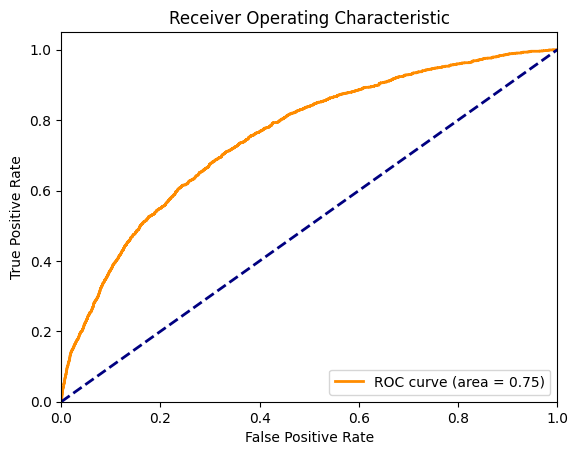

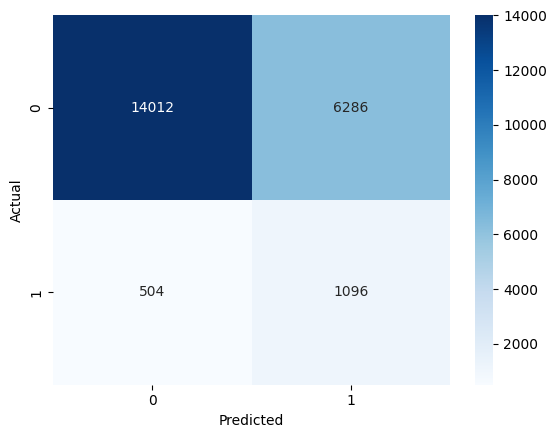

In [ ]:
X = application.drop(columns = ['TARGET'])
y = application['TARGET']

# stratified split
X_train, y_train, X_val, y_val, X_test, y_test = sorted_split(X, y, 'AMT_INCOME_TOTAL')
y_test = y_test.to_numpy()

# scale
columns_to_scale = ['AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY',
                    'AMT_GOODS_PRICE', 'EXT_SOURCE_1', 'EXT_SOURCE_2',
                    'EXT_SOURCE_3']

# transform
preprocessor = ColumnTransformer(
    transformers = [('scale', StandardScaler(), columns_to_scale)],
    remainder = 'passthrough')

X_train = preprocessor.fit_transform(X_train)
X_val = preprocessor.transform(X_val)
X_test = preprocessor.transform(X_test)


X_train, y_train, X_val, y_val, X_test, y_test = stratified_split(X, y)
y_test = y_test.to_numpy()

X_train = preprocessor.fit_transform(X_train)
X_val = preprocessor.transform(X_val)
X_test = preprocessor.transform(X_test)

# fit model
model = LogisticRegression(penalty = "l1",
                           solver = "saga",
                           class_weight='balanced')
model.fit(X_train, y_train)

# get predicitions and probabilities
y_pred = model.predict(X_test)
y_prob = model.decision_function(X_test)

# metrics
accuracy, precision, recall, f1_score = metrics(y_test, y_pred)
mcc = matthews_correlation_coefficient(y_test, y_pred)
rocauc_score = rocauc(y_test, y_prob)

print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1_score}')
print(f'MCC: {mcc}')
print(f'ROC AUC: {rocauc_score}')

# print out roc curve
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt

fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = roc_auc_score(y_test, y_prob)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

# print out the confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
# add labels for actual and predicted
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [6]:
from sklearn.svm import SVC

application = application.sample(n=50000, random_state=42)

X = application.drop(columns = ['TARGET'])
y = application['TARGET']

# # drop everything but AMT_INCOME_TOTAL, AMT_CREDIT, and AGE
# X = X[['AMT_INCOME_TOTAL', 'AGE']]


# scale
columns_to_scale = ['AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY',
                    'AMT_GOODS_PRICE', 'EXT_SOURCE_1', 'EXT_SOURCE_2',
                    'EXT_SOURCE_3']
# columns_to_scale = ['AMT_INCOME_TOTAL']

# transform
preprocessor = ColumnTransformer(
    transformers = [('scale', StandardScaler(), columns_to_scale)],
    remainder = 'passthrough')


X_train, y_train, X_val, y_val, X_test, y_test = stratified_split(X, y)
y_test = y_test.to_numpy()

X_train = preprocessor.fit_transform(X_train)
X_val = preprocessor.transform(X_val)
X_test = preprocessor.transform(X_test)

# fit model
# model = LogisticRegression(penalty = "l1",
#                            solver = "saga",
#                            class_weight='balanced')
model = SVC(gamma='auto', class_weight='balanced')
model.fit(X_train, y_train)

SVC(class_weight='balanced', gamma='auto')

In [7]:
# read in test data
test = pd.read_csv('./data/application_test.csv')
test = test.set_index('SK_ID_CURR')

test['AGE'] = round(test['DAYS_BIRTH'] / -365) # more interpretable age variable

# drop columns in test:
drop_cols1 = [
    'DAYS_BIRTH', 'DAYS_EMPLOYED', 'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH',
    'OWN_CAR_AGE', 'FLAG_MOBIL', 'FLAG_EMP_PHONE', 'FLAG_WORK_PHONE',
    'FLAG_CONT_MOBILE', 'FLAG_PHONE', 'FLAG_EMAIL', 'OCCUPATION_TYPE',
    'CNT_FAM_MEMBERS', 'REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY',
    'WEEKDAY_APPR_PROCESS_START', 'HOUR_APPR_PROCESS_START',
    'REG_REGION_NOT_LIVE_REGION', 'REG_REGION_NOT_WORK_REGION',
    'LIVE_REGION_NOT_WORK_REGION', 'REG_CITY_NOT_LIVE_CITY',
    'REG_CITY_NOT_WORK_CITY', 'LIVE_CITY_NOT_WORK_CITY', 'ORGANIZATION_TYPE', 'APARTMENTS_AVG',
    'BASEMENTAREA_AVG', 'YEARS_BEGINEXPLUATATION_AVG', 'YEARS_BUILD_AVG',
    'COMMONAREA_AVG', 'ELEVATORS_AVG', 'ENTRANCES_AVG', 'FLOORSMAX_AVG',
    'FLOORSMIN_AVG', 'LANDAREA_AVG', 'LIVINGAPARTMENTS_AVG', 'LIVINGAREA_AVG',
    'NONLIVINGAPARTMENTS_AVG', 'NONLIVINGAREA_AVG', 'APARTMENTS_MODE',
    'BASEMENTAREA_MODE', 'YEARS_BEGINEXPLUATATION_MODE', 'YEARS_BUILD_MODE',
    'COMMONAREA_MODE', 'ELEVATORS_MODE', 'ENTRANCES_MODE', 'FLOORSMAX_MODE',
    'FLOORSMIN_MODE', 'LANDAREA_MODE', 'LIVINGAPARTMENTS_MODE', 'LIVINGAREA_MODE',
    'NONLIVINGAPARTMENTS_MODE', 'NONLIVINGAREA_MODE', 'APARTMENTS_MEDI',
    'BASEMENTAREA_MEDI', 'YEARS_BEGINEXPLUATATION_MEDI', 'YEARS_BUILD_MEDI',
    'COMMONAREA_MEDI', 'ELEVATORS_MEDI', 'ENTRANCES_MEDI', 'FLOORSMAX_MEDI',
    'FLOORSMIN_MEDI', 'LANDAREA_MEDI', 'LIVINGAPARTMENTS_MEDI', 'LIVINGAREA_MEDI',
    'NONLIVINGAPARTMENTS_MEDI', 'NONLIVINGAREA_MEDI', 'FONDKAPREMONT_MODE',
    'HOUSETYPE_MODE', 'TOTALAREA_MODE', 'WALLSMATERIAL_MODE', 'EMERGENCYSTATE_MODE',
    'OBS_30_CNT_SOCIAL_CIRCLE', 'DEF_30_CNT_SOCIAL_CIRCLE', 'OBS_60_CNT_SOCIAL_CIRCLE',
    'DEF_60_CNT_SOCIAL_CIRCLE', 'DAYS_LAST_PHONE_CHANGE', 'FLAG_DOCUMENT_2',
    'FLAG_DOCUMENT_3', 'FLAG_DOCUMENT_4', 'FLAG_DOCUMENT_5', 'FLAG_DOCUMENT_6',
    'FLAG_DOCUMENT_7', 'FLAG_DOCUMENT_8', 'FLAG_DOCUMENT_9', 'FLAG_DOCUMENT_10',
    'FLAG_DOCUMENT_11', 'FLAG_DOCUMENT_12', 'FLAG_DOCUMENT_13', 'FLAG_DOCUMENT_14',
    'FLAG_DOCUMENT_15', 'FLAG_DOCUMENT_16', 'FLAG_DOCUMENT_17', 'FLAG_DOCUMENT_18',
    'FLAG_DOCUMENT_19', 'FLAG_DOCUMENT_20', 'FLAG_DOCUMENT_21', 'AMT_REQ_CREDIT_BUREAU_HOUR',
    'AMT_REQ_CREDIT_BUREAU_DAY', 'AMT_REQ_CREDIT_BUREAU_WEEK', 'AMT_REQ_CREDIT_BUREAU_MON',
    'AMT_REQ_CREDIT_BUREAU_QRT', 'AMT_REQ_CREDIT_BUREAU_YEAR'
]

test = test.drop(columns = drop_cols1)
test['CODE_GENDER'] = test['CODE_GENDER'].replace({'M': 1, 'F': 0})
test['FLAG_OWN_CAR'] = test['FLAG_OWN_CAR'].replace({'Y': 1, 'N': 0})
test['FLAG_OWN_REALTY'] = test['FLAG_OWN_REALTY'].replace({'Y': 1, 'N': 0})

categorical_var = ['NAME_CONTRACT_TYPE',
       'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE',
       'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE']
test = pd.get_dummies(test, categorical_var, dtype = int)

# # drop everything but AMT_INCOME_TOTAL, AMT_CREDIT, and AGE
# test = test[['AMT_INCOME_TOTAL', 'AGE']]

# fill missing values
missing_cols = set(X.columns) - set(test.columns)
for col in missing_cols:
    test[col] = 0

# reorder columns
test = test[X.columns]

# fill missing values
test = test.fillna(0)

# make copy of test
test_copy = test.copy()
test_copy.reset_index(inplace=True)

# scale
test = preprocessor.transform(test)

# get predictions and probabilities
y_pred = model.predict(test)
y_prob = model.decision_function(test)

sk_id_curr_test = test_copy['SK_ID_CURR']

# Create a DataFrame with SK_ID_CURR and predicted TARGET
predictions_df = pd.DataFrame({
    'SK_ID_CURR': sk_id_curr_test,
    'TARGET': y_pred  # Predicted values from the model
})

# Save to CSV
predictions_df.to_csv('predictions.csv', index=False)

print("CSV file 'predictions.csv' created successfully!")

CSV file 'predictions.csv' created successfully!
